In [35]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import nibabel as nib
import matplotlib.pyplot as plt
# there was some problems for using import tensorflow as tf
# the way I found to fix it is the next two lines
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()

import tensorflow as tf
import tensorflow.keras
import numpy as np
import os

import random

from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dense, GlobalAveragePooling3D
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv3D,MaxPooling3D, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import zoom

from tensorflow.keras.applications.vgg16 import VGG16

#reduce the size of model weights
from tensorflow.keras import backend as K
K.set_floatx('float32')

In [2]:
# #maybe I do not need this in future
# def getListOfFiles(dirName):
#     # create a list of file and sub directories 
#     # names in the given directory 
#     listOfFile = os.listdir(dirName)
#     allFiles = list()
#     # Iterate over all the entries
#     for entry in listOfFile:
#         # Create full path
#         fullPath = os.path.join(dirName, entry)
#         # If entry is a directory then get the list of files in this directory 
#         if os.path.isdir(fullPath):
#             allFiles = allFiles + getListOfFiles(fullPath)
#         elif fullPath[-4:]=='.nii': # to avoid DS_Store or other system files
#             allFiles.append(fullPath)
                
#     return allFiles

In [38]:
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)
    
    X_conv1 = Conv3D(8, (3, 3, 3), strides = (1, 1,1), padding='same', name = 'conv1',data_format="channels_last", activation='relu')(X_input)
    X_conv2 = Conv3D(8, (3, 3, 3), strides = (1, 1,1), padding='same', name = 'conv2',data_format="channels_last", activation='relu')(X_conv1)
    X_pool3 = MaxPooling3D(pool_size=(2,2,2), strides=None, data_format=None, name = 'pool3')(X_conv2) # it should be 5,5,5,

    
    X_conv4 = Conv3D(16, (3, 3, 3), strides = (1, 1,1), padding='same', name = 'conv4',data_format="channels_last", activation='relu')(X_pool3)
    X_conv5 = Conv3D(16, (3, 3, 3), strides = (1, 1,1), padding='same', name = 'conv5',data_format="channels_last", activation='relu')(X_conv4)
    X_pool6 = MaxPooling3D(pool_size=(2,2,2), strides=None, data_format=None, name = 'pool6')(X_conv5) # it should be 5,5,5,

    
    X_conv7 = Conv3D(32, (3, 3, 3), strides = (1, 1,1), padding='same', name = 'conv7',data_format="channels_last", activation='relu')(X_pool6)
    X_conv8 = Conv3D(32, (3, 3, 3), strides = (1, 1,1), padding='same', name = 'conv8',data_format="channels_last", activation='relu')(X_conv7)
    X_conv8 = Conv3D(32, (3, 3, 3), strides = (1, 1,1), padding='same', name = 'conv8-1',data_format="channels_last", activation='relu')(X_conv8)
    X_pool9 = MaxPooling3D(pool_size=(2,2,2), strides=None, data_format=None, name = 'pool9')(X_conv8) # it should be 5,5,5,

    
    X_conv10 = Conv3D(64, (3, 3, 3), strides = (1, 1,1), padding='same', name = 'conv10',data_format="channels_last", activation='relu')(X_pool9)
    X_conv11 = Conv3D(64, (3, 3, 3), strides = (1, 1,1), padding='same', name = 'conv11',data_format="channels_last", activation='relu')(X_conv10)
    X_conv11 = Conv3D(64, (3, 3, 3), strides = (1, 1,1), padding='same', name = 'conv11-1',data_format="channels_last", activation='relu')(X_conv11)
    X_pool12 = MaxPooling3D(pool_size=(2,2,2), strides=None, data_format=None, name = 'pool12')(X_conv11) # it should be 5,5,5,

    X_flat13 = Flatten()(X_pool12)
        
    X_dense14 = Dense(128, activation='relu', name='fc14')(X_flat13)
    
    X_batch15 = BatchNormalization()(X_dense14)
    
    X_Drop16 = Dropout(rate=0.5)(X_batch15, training=True)
    
    X_dense17 = Dense(64, activation='relu', name='fc17')(X_Drop16)
    
    X_out18 = Dense(1, activation='sigmoid', name='out')(X_dense17)
        
    
    model = Model(inputs = X_input, outputs = X_out18, name='HappyModel')    
    
    return model

In [39]:
model1 = model ((110,110,110,1))

TypeError: __init__() got an unexpected keyword argument 'inputs'

In [41]:
#Builds keras 3D CNN model
def build_cnn(dimension = '3d', activation = 'softmax', heatmap = False, w_path = None, compile_model = True):
    input_3d = (img_size_x, img_size_y, img_size_z, 1)
    
    #VoxCNN architecture
    
    model = Sequential()
    # 1st Volumetric Convolutional block
    model.add(Conv3D(8, (3, 3, 3), activation='relu', padding='same', input_shape=input_3d))
    model.add(Conv3D(8, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # 2nd Volumetric Convolutional block
    model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # 3rd Volumetric Convolutional block
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # 4th Volumetric Convolutional block
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    # 1th Deconvolutional layer with batchnorm and dropout for regularization
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # 2th Deconvolutional layer
    model.add(Dense(64, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    # Output with softmax nonlinearity for classification
    model.add(Dense(1, activation='sigmoid'))
    
    return model
model1 = build_cnn(dimension = '3d', compile_model = True)

In [42]:
# #load model weights, note that we will only use the weights for the convolution layer
# model1.load_weights('new_weights_1.h5')

In [43]:
#Parameters (Modify as needed)
img_size_x = 110
img_size_y = 110
img_size_z = 110

batch_size = 10
classes = 2
epochs = 50
lr = 27*1e-6

early_stopping_patience = 20
class_names = ['NC', 'AD']

In [44]:
# def getImage( subject, directory ):

#     epi_img = nib.load(directory + subject + '.nii')
#     epi_img_data = epi_img.get_fdata()
    
# #     v_min = epi_img_data.min(axis=(0, 1, 2), keepdims=True)
# #     v_max = epi_img_data.max(axis=(0, 1, 2), keepdims=True)
# #     epi_img_data = (epi_img_data - v_min)/(v_max - v_min)
        
#     return epi_img_data

In [45]:
def load_dataset_clean():
    AD_directory = "/home/ubuntu/project/Data/AD_clean/"
    NC_directory = "/home/ubuntu/project/Data/NC_clean/"
    
    AD_list = os.listdir(AD_directory)
    NC_list = os.listdir(NC_directory)
    

    All_directory = "/home/ubuntu/project/Data/AD_NC_Clean/"

    X = np.zeros((111,img_size_x,img_size_y,img_size_z,1))
    Y = np.zeros(111)
    
    l = os.listdir(All_directory)
    random.shuffle(l)
   
    
    objindex = 0
    for i, filename in enumerate(l):
        if (filename.startswith('.')):
            print ("hidden file")
        else:
            epi_img = nib.load(All_directory + filename)
            x = epi_img.get_fdata()
            x = (x-x.min())/x.max()
            
            x = np.expand_dims(x, axis=3)
            X[objindex] = x
            y = 0
            if filename in AD_list:
                y = 1
                
            Y[objindex] = y
            
            objindex += 1
            
    return X, Y

In [27]:
X, Y = load_dataset_clean()

In [79]:
#load model weights, note that we will only use the weights for the convolution layer
from tensorflow.keras import losses
# model1.load_weights('my_model_weights_0_14.h5')
# opt = keras.optimizers.Adadelta(clipnorm=1.)
opt = tf.keras.optimizers.Adam(lr=0.0001,beta_1=0.9, beta_2=0.99, amsgrad=False)
# def batch_callback():
#     print('hello')
    
model1.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

# model1.compile(loss=losses.mean_squared_error, optimizer='sgd', metrics=['categorical_accuracy'])


m = model1.fit(X[0:70],Y[0:70],validation_data=(X[70:100],Y[70:100]),batch_size=5,epochs=100, verbose=1)
# model1.train_on_batch(X[0:10], Y[0:10])

Train on 70 samples, validate on 30 samples
Epoch 1/100
70/70 [==============================] - 26s 373ms/sample - loss: 0.7491 - acc: 0.5571 - val_loss: 3.2305 - val_acc: 0.5333
Epoch 2/100
70/70 [==============================] - 18s 253ms/sample - loss: 0.7100 - acc: 0.5571 - val_loss: 3.6217 - val_acc: 0.5333
Epoch 3/100
70/70 [==============================] - 18s 255ms/sample - loss: 0.7085 - acc: 0.5286 - val_loss: 2.8047 - val_acc: 0.5333
Epoch 4/100
70/70 [==============================] - 18s 254ms/sample - loss: 0.6718 - acc: 0.5857 - val_loss: 1.7247 - val_acc: 0.5333
Epoch 5/100
70/70 [==============================] - 18s 255ms/sample - loss: 0.7560 - acc: 0.5286 - val_loss: 1.5072 - val_acc: 0.5333
Epoch 6/100
70/70 [==============================] - 18s 254ms/sample - loss: 0.7312 - acc: 0.4857 - val_loss: 1.5858 - val_acc: 0.5333
Epoch 7/100
70/70 [==============================] - 18s 257ms/sample - loss: 0.6833 - acc: 0.5857 - val_loss: 0.8912 - val_acc: 0.5333
Epoc

70/70 [==============================] - 18s 257ms/sample - loss: 0.2593 - acc: 0.9429 - val_loss: 0.4494 - val_acc: 0.7667
Epoch 61/100
70/70 [==============================] - 18s 257ms/sample - loss: 0.2299 - acc: 0.9143 - val_loss: 0.4471 - val_acc: 0.7667
Epoch 62/100
70/70 [==============================] - 18s 256ms/sample - loss: 0.2076 - acc: 0.9571 - val_loss: 0.5137 - val_acc: 0.7000
Epoch 63/100
70/70 [==============================] - 18s 257ms/sample - loss: 0.1677 - acc: 0.9571 - val_loss: 1.7480 - val_acc: 0.5667
Epoch 64/100
70/70 [==============================] - 18s 256ms/sample - loss: 0.2411 - acc: 0.9429 - val_loss: 0.4240 - val_acc: 0.7333
Epoch 65/100
70/70 [==============================] - 18s 258ms/sample - loss: 0.1790 - acc: 0.9571 - val_loss: 1.0397 - val_acc: 0.6000
Epoch 66/100
70/70 [==============================] - 18s 256ms/sample - loss: 0.1006 - acc: 1.0000 - val_loss: 0.3779 - val_acc: 0.8667
Epoch 67/100
70/70 [==============================] - 

In [80]:
model1.save_weights('Moha-Final-voxnet.h5')

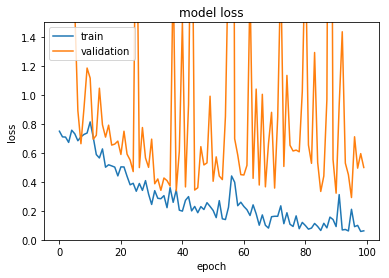

In [81]:
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim(0,1.5)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

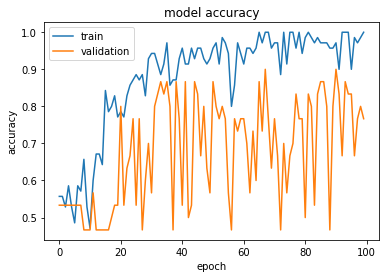

In [82]:
plt.plot(m.history['acc'])
plt.plot(m.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [54]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

<class 'numpy.ndarray'>


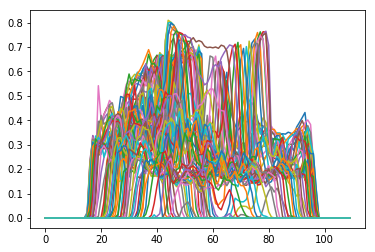

In [61]:
n_i, n_j, n_k, g = X[0].shape
fig = plt.plot(X[0][55].reshape(110,110))
print(type(X))

TypeError: Invalid dimensions for image data

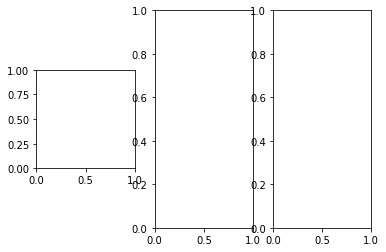

In [56]:
epi_img_data = X[0]
center_i = (n_i - 1) // 2  # // for integer division
center_j = (n_j - 1) // 2
center_k = (n_k - 1) // 2
slice_0 = epi_img_data[center_i, :, :]
slice_1 = epi_img_data[:, center_j, :]
slice_2 = epi_img_data[:, :, center_k]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image") 

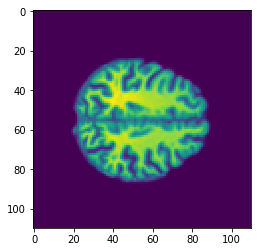

In [75]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(X[100][:,:,70].reshape(110,110))